In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
data = pd.read_csv('data/res_evaluated.csv')

pd.set_option('display.max_columns',200)

1) В рамках тесту 1 сформулювати задачу розподілу мотивацій для свого курсів як задачу перевірки статистичних гіпотез про розподіл даних,  розв’язати вручну (Excel)  використати критерій Пірсона

За допомогою критерію Пірсона перевіримо чи оцінки з 1го тесту для ПМ-4 розподілені нормально. Для цього створимо таблицю частот 

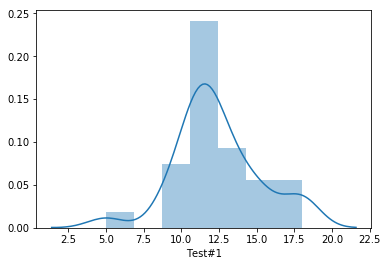

In [2]:
test1 = data[data['Курс']==4]['Test#1']
sns.distplot(test1);

In [3]:
bins = np.arange(0,20,5)
mapped_bins = np.digitize(test1,bins,right=False)
grouped_test1 = test1.groupby(by=mapped_bins).count()
grouped_test1[1]=0
grouped_test1.sort_index(inplace=True)

test1_data = pd.DataFrame(np.array([bins,grouped_test1.values]).T,columns=['interval','freq'])
test1_h,test1_c = 5,12
print("Observed frequencies:")
test1_data

Observed frequencies:


,interval,freq
0,0,0
1,5,3
2,10,20
3,15,6


In [4]:
#Chi squared custom calculator
class Xi_squared_calculator:
    def calculate_x_dash(self,x):
        return (x-self.c)/self.h
    
    def __init__(self,data, h, c):
        """
            data -- pd.DataFrame [interval, freq]
        """
        self.data = data
        self.h,self.c = h,c

        self.size = self.data.freq.sum()
        self.data_transformed = self.transform_data()
        
        self.dash_mean, self.dash_var = self.dash_moments()
        self.empirical_mean, self.empirical_var, self.empirical_std = self.empirical_moments()
        
        self.tf_df = self.theoretical_freq_table()#theoretical freq
        self.chi_df = self.chi_observed_table()
        
        self.chi_approx = self.chi_df.chi.sum()
        
    def transform_data(self):
        data_transformed = self.data.assign(
            x_dash=lambda x: self.calculate_x_dash(x.interval),
            x_dash_freq = lambda x: x.x_dash*x.freq,
            x_dash_freq_squared = lambda x: x.x_dash_freq * x.x_dash)        
        return data_transformed
        
    def dash_moments(self):
        dash_mean = self.data_transformed.x_dash_freq.sum()/self.size
        dash_var = self.data_transformed.x_dash_freq_squared.sum()/self.size - dash_mean**2
        return dash_mean,dash_var
    
    def empirical_moments(self):
        empricial_mean = self.dash_mean * self.h + self.c
        empirical_var = self.dash_var * self.h**2
        return empricial_mean,empirical_var, np.sqrt(empirical_var)
            
    def theoretical_freq_table(self):
        k = self.size * self.h / self.empirical_std
        tf_df = pd.DataFrame(self.data.interval)
        tf_df = tf_df.assign(
            u = lambda x: (x - self.empirical_mean) / self.empirical_std,
            phi = lambda x: stats.norm.pdf(x.u),
            n_i = lambda x: k * x.phi)
        return tf_df
    
    def chi_observed_table(self):
        chi_df = pd.DataFrame(np.array([self.data_transformed.freq, self.tf_df.n_i]).T, columns=['observed_freq','theor_freq'])
        chi_df = chi_df.assign(
            diff = lambda x: (x.observed_freq - x.theor_freq),
            diff_squared =  lambda x: x['diff'] **2,
            chi = lambda x: x.diff_squared / x.theor_freq)        
        return chi_df
    
    
    def get_chi_approx(self):
        return self.chi_approx

#Приклад з лекції:
test_df =  pd.DataFrame(np.array([np.arange(5,22,2),np.array([15,26,25,30,26,21,24,20,13])]).T, columns=['interval','freq'])

c2p = Xi_squared_calculator(test_df,2,13)
print(f'custom chi_2={c2p.chi_approx}')
print(f'Scipy stats alternative: {stats.chisquare(c2p.chi_df.observed_freq,c2p.chi_df.theor_freq,ddof = 3)}')
print(f'chi^2_critical = {stats.chi2.ppf(0.95,9-3)}')

custom chi_2=22.424820220293732
Scipy stats alternative: Power_divergenceResult(statistic=22.424820220293732, pvalue=0.0004346526839824956)
chi^2_critical = 12.591587243743977


In [5]:
c2p = Xi_squared_calculator(test1_data,test1_h,test1_c)
print(f'chi^2_observed = {c2p.chi_approx} with chi_2_critical={stats.chi2.ppf(0.95,1)}')
print(stats.chisquare(c2p.chi_df.observed_freq, c2p.chi_df.theor_freq,ddof=3))
print(f'Пораховане значення повністю співпадає з тестом з бібліотеки та менше за критичне значення Ксі квадрат\np-value={stats.chi2.sf(stats.chi2.ppf(0.95,1),3):.4f}>0.05=alpha-рівень значущості\nНе можемо відхилити гіпотезу про нормальність')

chi^2_observed = 0.10043218315783131 with chi_2_critical=3.841458820694124
Power_divergenceResult(statistic=0.10043218315783131, pvalue=nan)
Пораховане значення повністю співпадає з тестом з бібліотеки та менше за критичне значення Ксі квадрат
p-value=0.2791>0.05=alpha-рівень значущості
Не можемо відхилити гіпотезу про нормальність


2) В рамках тесту 2 сформулювати задачу порівняння мотивацій для різних курсів як задачу перевірки статистичних гіпотез про однорідність даних, розв’язати вручну (Excel), використати: 
*  Т-критерій Стьюдента 

Припустимо, що розподіли мотивацій другого тесту для 2го та 4го курсів ПМ мають однакове матсподівання. Перевіримо це за допомогою Т-критерію:
Сформулюємо гіпотези: 
*  H0: $E(a_1) = E(a_2)$ (вибірки є однаковими)
*  H1: $E(a_1)\ne E(a_2)$

In [6]:
seniors = data.loc[data['Курс']==4]['Test#2: Аналіз даних']
sophomores = data.loc[data['Курс']==2]['Test#2: Аналіз даних']
print(f'{seniors.size} seniors with mean={seniors.mean():.4f} and variance={seniors.var():.4f}')
print(f'{sophomores.size} sophomores with mean={sophomores.mean():.4f} and variance = {sophomores.var():.4f}')

29 seniors with mean=10.0690 and variance=3.4236
29 sophomores with mean=10.2759 and variance = 3.9212


In [7]:
def empirical_error(x,y,k=2):
    n,m = x.size, y.size
    
    coef1 = np.sqrt(n*m/n+m)
    coef2 = np.sqrt( (n-1)*x.var()+ (m-1)*y.var() / (n+m-k))
    
    return coef1 * (x.mean()-y.mean())/ coef2

theoretical_error = stats.t.ppf(0.975,sophomores.shape[0]*2-2)
print(f'empirical error={empirical_error(sophomores,seniors):.4f}<{theoretical_error:.4f}=theoretical error. H0 cannot be rejected\n Не можемо відхилити H0')

empirical error=0.1492<2.0032=theoretical error. H0 cannot be rejected
 Не можемо відхилити H0


*  Критерій знаків 

Перевіримо гіпотези: 
*  H0: $a_1 = a_2$ (вибірки є однаковими)
*  H1: $a_1\ne a_2$

In [8]:
def f1(r,k):
    return r/(k-r+1)

def f1_theor(r,size):
    return stats.f.ppf(0.975,2*(size-r+1),2*r)

def f2(r,k):
    return (k-r)/(r+1)

def f2_theor(r,k):
    return stats.f.ppf(0.975,2*(r+1),2*(k-r))

df = pd.DataFrame(np.array([sophomores,seniors]).T, columns=['second_year','forth_year'])
df = df.assign(sign = lambda x: np.sign(x.second_year-x.forth_year))
k = df[df.sign!=0].shape[0]
r = df[df.sign>0].shape[0]
df[:5]

,second_year,forth_year,sign
0,11,9,1
1,10,7,1
2,10,9,1
3,9,9,0
4,8,9,-1


In [9]:
print(f'positives={r}\nnegatives={df.shape[0]-k}\nf1={f1(r,k):.4f}<f1_theor={f1_theor(r,df.shape[0]):.4f}\nf2={f2(r,k):.4f}<f2_theor={f2_theor(r,k)}\nf-Статистика для обох величин менша за теоретичний рівень значущості. Не можемо відхилити гіпотезу H0')

positives=17
negatives=1
f1=1.4167<f1_theor=2.0509
f2=0.6111<f2_theor=2.230700045743092
f-Статистика для обох величин менша за теоретичний рівень значущості. Не можемо відхилити гіпотезу H0


*  критерій Вілкоксона 
 
Перевіримо гіпотезу про змішаність виборок розподілів мотивації в 2му тесті для ПМ-2 та ПМ-4 та рівність їх генеральних середніх

In [10]:
def calculate_ranks(x):
    k2indices = {}
    for i,el in enumerate(x):
        if el in k2indices:
            k2indices[el].append(i+1)
        else:
            k2indices[el]=[i+1]
    key2rank = {k:sum(k2indices[k])/len(k2indices[k]) for k in k2indices.keys()}
    return k2indices,key2rank

def calculate_total_rank(k2r, x):
    return sum(k2r[el] for el in x)

def empirical_rank(x,y):
    joined_arr = np.sort(np.concatenate((x.values,y.values)))
    if x.size>y.size:
        x,y=y,x
    
    key2rank = calculate_ranks(joined_arr)[1]
    return calculate_total_rank(key2rank,x)

def theoretical_rank(x,y,z_a=-1.96):
    n,m=x.size, y.size

    return n*(n+m+1)/2 + z_a*np.sqrt(n*m*(n+m+1)/12)

def theoretical_interval(x,y):
    n,m = x.size,y.size
    return n*(n+m-1)

em_rank = empirical_rank(sophomores,seniors)
th_rank = theoretical_rank(sophomores,seniors)
th_int = theoretical_interval(sophomores,seniors)
print(f'empirical rank={em_rank},theoretical rank={th_rank:.4f},upper_bound={th_int-th_rank:.4f}\nМожемо прийняти гіпотезу')

empirical rank=872.0,theoretical rank=729.4655,upper_bound=923.5345
Можемо прийняти гіпотезу


* критерій Мана-Уітні.

Перевіримо гіпотезу про достовірність відмінностей між значеннями параметрів у вибірках результатів 2го тесту на мотивацію для студентів ПМ-2 та ПМ-4
* Зауважимо, що n>20, отже таблицю критичних значень використовувати не можемо. Натомість, обчислимо p-value

In [11]:
def mann_whitney_u_test(x,y):
    n,m = x.shape[0],y.shape[0]
    
    joined_arr = np.sort(np.concatenate((x.values,y.values)))
    key2rank = calculate_ranks(joined_arr)[1]
    x_rank,y_rank = calculate_total_rank(key2rank,x), calculate_total_rank(key2rank,y)
    
    if x_rank>=y_rank:
        max_rank,n_max = x_rank, n
    else:
        max_rank,n_max = y_rank,m
    
    U = n*m + n_max*(n_max+1)*0.5 - max_rank
    return U

def calc_p_val(U,x,y):   
    n1,n2 = x.shape[0],y.shape[0]
    mean_rank = n1*n2/2
    
    T = stats.tiecorrect(np.sort(np.concatenate((sophomores.values,seniors.values))))
    
    sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)
    z= (U-mean_rank)/sd
    return 1-stats.distributions.norm.sf(z)

def mann_whitney_crit_values(x,y):
    n1,n2 = x.shape[0], y.shape[0]
    U = mann_whitney_u_test(x,y)
        
    return abs(U-n1*n2*0.5)/np.sqrt(n1*n2*(n1+n2+1)/12)

U = mann_whitney_u_test(sophomores,seniors)
print(f'U={U}, p_val={calc_p_val(U,sophomores,seniors)}<0.5=alpha - рівень значущості')
print(f'Результат співпадає з бібліотекою: {stats.mannwhitneyu(sophomores,seniors,use_continuity=False)}\nНе можемо прийняти гіпотезу')

U=404.0, p_val=0.39699453831249776<0.5=alpha - рівень значущості
Результат співпадає з бібліотекою: MannwhitneyuResult(statistic=404.0, pvalue=0.39699453831249776)
Не можемо прийняти гіпотезу


3) висновок в предметній області.

Ми сформували та перевірили наступні гіпотези:
* нормальність оцінки з першого тесту для ПМ-4. Перевіряли за допомогою Хі-критерію, не можемо відхилити нульову гіпотезу
* Однорідність розподілів оцінок з 2го тесту для ПМ-2 та ПМ-4. (рівність їхніх мат. сподівань) За Критерієм Стюдента, вибірки є однаковими (не можемо відхилити H0)
* Однорідність розподілів оцінок з 2го тесту для ПМ-2 та ПМ-4. За Критерієм знаків, так само не можемо відхилити цю гіпотезу.
* Рівність матсподівань тих самих оцінок за критерієм Вілкоксона: обчислене емпірічне значення W входить до теор. інтервалу прийняття гіпотези (ближче до верхньої межі). Так само не можемо відхилити H0
* Достовірність відмінностей між вибірками (оцінки з 2го тесту для ПМ-2 та ПМ-4) за критерієм Манна-Уітні. Через розмір вибірки не можемо використовувати табличні критичні значення, отриманий p-value дозволяє не прийняти нуль-гіпотезу.

Отже, за даними стат. критеріями, не можемо відхилити гіпотези про нормальність оцінок з 1го тесту для ПМ-4 та про однорідність розподілів оцінок з другого тесту для ПМ-2 та ПМ-4